In [8]:
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import os
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm, trange
import time
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score
from efficientnet_pytorch import EfficientNet
import cv2
import pandas as pd

In [9]:
seed = 42
torch.cuda.get_device_name()

'Tesla T4'

In [10]:
labels = pd.read_csv("../input/SampleSubmission.csv")

In [11]:
BATCH_SIZE = 2**4
NUM_WORKERS = 4
LEARNING_RATE = 5e-5
NUM_EPOCHS = 15
LOG_FREQ = 50
TIME_LIMIT = 8 * 60 * 60
RESIZE = 512
torch.cuda.empty_cache()

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# classes

In [27]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, mode):
        assert mode in ['train', 'val', 'test']

        self.df = dataframe
        self.mode = mode

        transforms_list = [
            transforms.Resize(RESIZE),
            transforms.CenterCrop(RESIZE)
        ]

        if self.mode == 'train':
            transforms_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomChoice([
                    transforms.RandomAffine(degrees=(0,180), translate=(0.1, 0.1),
                                            scale=(0.9, 1.1))
                ])
            ])

        transforms_list.extend([
            transforms.ToTensor(),
            #             transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                                   std=[0.229, 0.224, 0.225]),
        ])
        self.transforms = transforms.Compose(transforms_list)

    def __getitem__(self, index):
        ''' Returns: tuple (sample, target) '''
        filename = self.df['Id'].values[index] if self.mode == 'test' else self.df['Filename'].values[index]

        directory = '../input/Test' if self.mode == 'test' else '../input/output_combined2'
        sample = Image.open(f'./{directory}/gb_{filename}')
        image = self.transforms(sample)

        if self.mode == 'test':
            return image
        else:
            return image, self.df['Drscore'].values[index]

    def scaleRadius(self, img, scale):
        x = img[img.shape[0]//2,:,:].sum(1)
        r = (x > x.mean() / 10).sum() / 2
        s = scale * 1.0 / r
        return cv2.resize(img, (0, 0), fx=s, fy=s)

    def __len__(self):
        return self.df.shape[0]

In [79]:
def inference(data_loader, model):
    ''' Returns predictions and targets, if any. '''
    model.eval()

    activation = nn.Softmax(dim=1)
    all_predicts, all_confs, all_targets = [], [], []

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            if data_loader.dataset.mode != 'test':
                input_, target = data
            else:
                input_, target = data, None

            output = model(input_.to(device))
            output = activation(output)

            confs, predicts = torch.topk(output, 1)
            all_confs.append(confs)
            all_predicts.append(predicts)

            if target is not None:
                all_targets.append(target)

    predicts = torch.cat(all_predicts)
    confs = torch.cat(all_confs)
    targets = torch.cat(all_targets) if len(all_targets) else None

    return predicts, confs, targets

In [80]:
def generate_submission(test_loader, model, label_encoder):
    sample_sub = pd.read_csv('../SampleSubmission.csv')

    predicts_gpu, confs_gpu, _ = inference(test_loader, model)
    predicts, confs = predicts_gpu.cpu().numpy(), confs_gpu.cpu().numpy()

    labels = [label_encoder.inverse_transform(pred) for pred in predicts]
    print('labels')
    print(np.array(labels))
    print('confs')
    print(np.array(confs))

    sub = test_loader.dataset.df
    def concat(label: np.ndarray, conf: np.ndarray) -> str:
        return ' '.join([f'{L} {c}' for L, c in zip(label, conf)])
    sub['landmarks'] = [concat(label, conf) for label, conf in zip(labels, confs)]

    sample_sub = sample_sub.set_index('id')
    sub = sub.set_index('id')
    sample_sub.update(sub)

    sample_sub.to_csv('submission.csv')

# model

In [30]:
test_dataset = ImageDataset(labels, mode='test')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS)

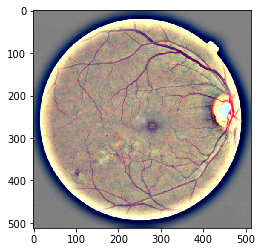

In [35]:
plt.imshow(test_dataset[0].permute(1, 2, 0))

In [76]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=5)

Loaded pretrained weights for efficientnet-b4


In [77]:
model = model.to(device)
model = nn.DataParallel(model)

In [78]:
model.load_state_dict(torch.load("../model/final_EN_10.ptm"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [81]:
predicts, confs, targets = inference(test_loader, model)

100%|██████████| 63/63 [00:32<00:00,  1.29it/s]


In [82]:
labels['Expected'] = predicts.cpu().numpy()

In [83]:
labels.head()

,Id,Expected
0,test_image1.tif,2
1,test_image2.tif,0
2,test_image3.tif,0
3,test_image4.tif,2
4,test_image5.tif,0


In [84]:
labels.to_csv("../submissions/usyd_ENb4_10.csv", index=False)